## Analyze ArtEmis dataset along some basic axis regarding the emotions indicated & the language characteristics.

#### Assumes you have downloaded the dataset. Please adapt the directory locations for the preprocessed ArtEmis data + the WikiArt images.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from functools import partial
from ast import literal_eval

from artemis.in_out.basics import show_random_captions
from artemis.emotions import ARTEMIS_EMOTIONS, LARGER_EMOTION_VOCAB, positive_negative_else
from artemis.analysis.emotion_centric import df_to_emotion_histogram, has_emotion_max_dominance
from artemis.evaluation.metaphors import metaphorical_substrings

import os
from os import listdir
from os.path import isfile, join

sns.set()
%load_ext autoreload
%autoreload 2

In [2]:
##
## Change these two directories to your local top-directories.
##
artemis_preprocessed_csv = '/Users/sen/Documents/University/Leiden/3/Advances_Neural_Nets/deep_processed/artemis_preprocessed.csv'
wikiart_subset_img_dir = '/Users/sen/Documents/University/Leiden/3/Advances_Neural_Nets/wikiart_subset'
#wikiart_img_dir = '/Users/sen/Documents/University/Leiden/3/Advances_Neural_Nets/wikiart'
save_figs = False # to save the output figures generated or not.

In [3]:
# Files provided in the code-repo to help the analysis.
glove_vocab_file = '/Users/sen/artemis/artemis/data/glove.6B.100d.vocabulary.txt'
wikiart_genre_labels_file = '/Users/sen/artemis/artemis/data/wiki_art_genre_class.csv'

In [4]:
# load preprocessed file with annotations.
df = pd.read_csv(artemis_preprocessed_csv)
df.tokens = df.tokens.apply(literal_eval) # to make them a python list.
print(f'{len(df)} annotations were loaded.')

429431 annotations were loaded.


In [5]:
# Add a label to indicate if the emotion is positive or negative or Something-Else
df = df.assign(pne = df.emotion.apply(positive_negative_else))

In [6]:
##
## Basic Stats
##
print('Token Length:')
print('Average', df.tokens_len.mean(), 'Median', df.tokens_len.median(), 'Max', df.tokens_len.max())

grouped_artwork = df.groupby(['art_style', 'painting'])
print('Unique paintings annotated:', len(grouped_artwork.size()))
print('Average annotators per painting:', grouped_artwork.size().mean())

Token Length:
Average 14.735843476600431 Median 14.0 Max 30
Unique paintings annotated: 80030
Average annotators per painting: 5.365875296763714


In [7]:
# Unique Tokens.
u_tokens = set()
df.tokens.apply(lambda x: [u_tokens.add(i) for i in x]);
print('Upper bound on unique tokens (vocab size). ', len(u_tokens))

Upper bound on unique tokens (vocab size).  35410


In [8]:
##
## Enrich the Dataframe with meta-data.
##

# Add art-genre labels from WikiArt (not all artworks have this). Makes new data-frame.
genre_info = pd.read_csv(wikiart_genre_labels_file)
df_with_genre = pd.merge(df, genre_info, on=['art_style', 'painting'])
print('Not all paintings have a genre label, the reduced set of ArtEmis on those who have is', len(df_with_genre))
print('Percentages of ArtEmis utterances in each art-genre:')
genre_info.groupby('genre').describe()['art_style']['count'] / len(genre_info)

Not all paintings have a genre label, the reduced set of ArtEmis on those who have is 341739
Percentages of ArtEmis utterances in each art-genre:


genre
abstract_painting     0.0764366
cityscape             0.0708208
genre_painting         0.167074
illustration          0.0292638
landscape              0.205524
nude_painting         0.0295869
portrait                0.21714
religious_painting     0.100592
sketch_and_study      0.0606662
still_life            0.0428956
Name: count, dtype: object

In [9]:
# for use on smaller wikiart subset data

# collect folder names and filter data

dict_lst, file_lst = [], []

for root, dirs, files in os.walk("/Users/sen/Documents/University/Leiden/3/Advances_Neural_Nets/wikiart_subset", topdown=False):
    for name in dirs:
        dict_lst.append(os.path.join(root, name))

for eachfolder in range(len(dict_lst)):
    file_lst += [f for f in listdir(dict_lst[eachfolder]) if isfile(join(dict_lst[eachfolder], f))]
subset_files = [s.strip('.jpg') for s in file_lst]
intersec = list(set(subset_files) & set(list(df['painting'])))
df_new = df
df_new['bool_index'] = df_new["painting"].isin(intersec)
df_subset = df_new.loc[df_new['bool_index'] == True]

Expressionism martiros-saryan_riders-at-the-river-1904


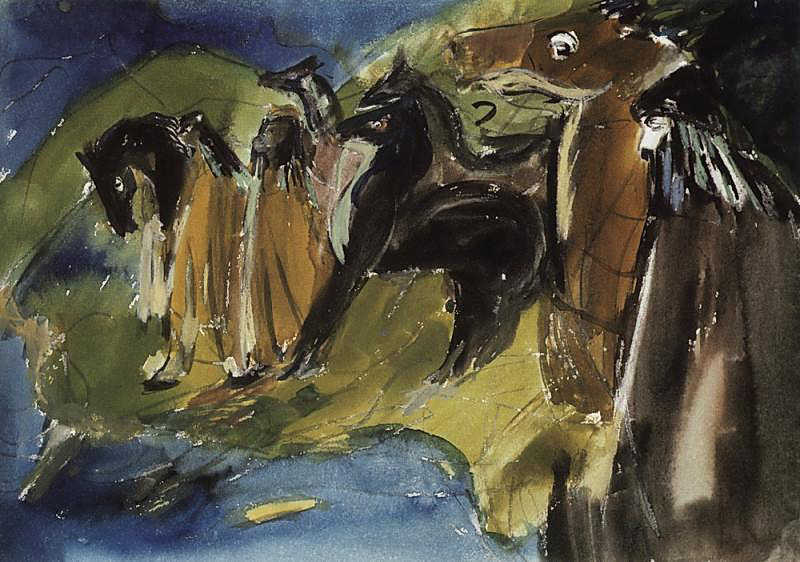

ANGER:	It appears that the people are trying to force the horses to go into a body of water and that the horses are afraid to go into the water.
FEAR:	The wide eyes and posture of the horses along with the dark colors suggest that they are spooked.
SOMETHING ELSE:	It's confusing, at first I saw a bat, but then I notice horses under his left wing.
SOMETHING ELSE:	I identify as the horse, and whatever the horses are afraid of in this picture; fear?
DISGUST:	I think it's meant to be horses but the colors are too dark on top of each other.


In [10]:
# for use on original full wikiart data
# show_random_captions(df, wikiart_img_dir)

# for use on smaller wikiart subset data
show_random_captions(df_subset, wikiart_subset_img_dir)


Expressionism chaim-soutine_portrait-of-madame-x-also-known-as-pink-portrait


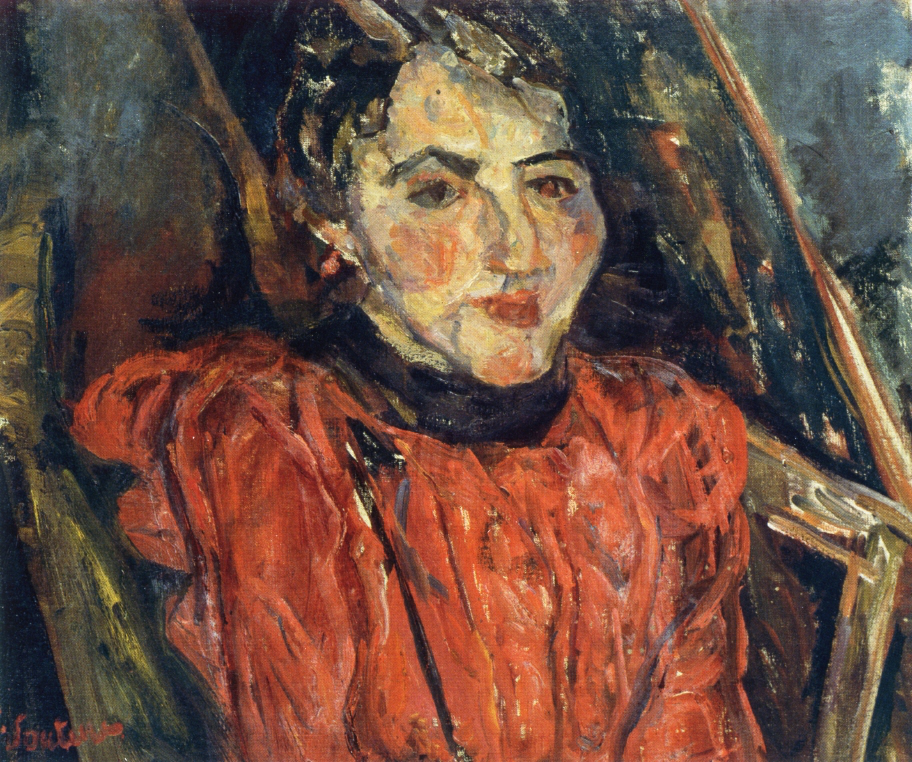

FEAR:	The woman looks scary. Her face is very serious and with all the dark colors makes it seem as if I should fear her
CONTENTMENT:	The woman looks like she's taking a trip somewhere.
AWE:	It kind of looks like the person has clown make up on.
SOMETHING ELSE:	I feel unsettled and it because if how red the checks are and how pointy the face is.
SADNESS:	This is kinda sad with the colors used to depict the woman sitting. She looks almost like shes sick maybe


In [46]:
# for use on original full wikiart data

# Show captions for a random portait.
#sb = df_with_genre[df_with_genre.genre == 'portrait']
#show_random_captions(sb, wikiart_img_dir)


# for use on smaller wikiart subset data

# filter data and create subset
genre_intersec = list(set(subset_files) & set(list(df_with_genre['painting'])))
df_new_with_genre = df_with_genre
df_new_with_genre['bool_index'] = df_new_with_genre["painting"].isin(genre_intersec)
df_subset_with_genre = df_new_with_genre.loc[df_new_with_genre['bool_index'] == True]
df_subset_with_genre[df_subset_with_genre.genre == 'portrait']

sb = df_subset_with_genre[df_subset_with_genre.genre == 'portrait']
show_random_captions(sb, wikiart_subset_img_dir)

[<Figure size 864x288 with 1 Axes>, <Figure size 576x288 with 1 Axes>]

<Figure size 432x288 with 0 Axes>

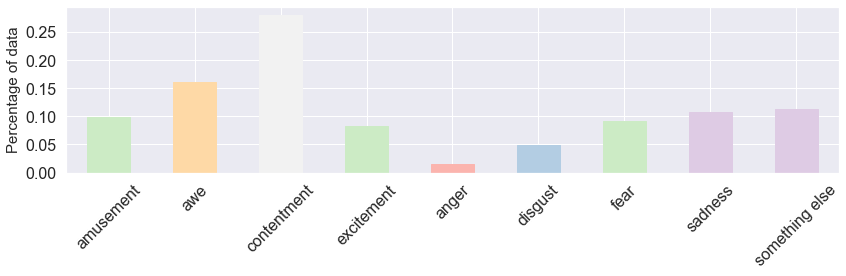

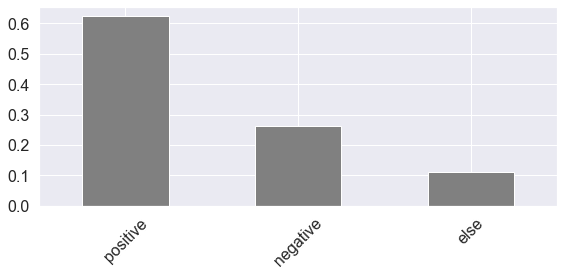

In [11]:
##
## make a histogram of the emotions
##
df_to_emotion_histogram(df)

In [49]:
df.groupby('pne')['emotion'].count() / len(df)

pne
0    0.623788
1    0.263810
2    0.112402
Name: emotion, dtype: float64

In [50]:
## Quick analysis on emotions and subjectivity.  (this can take up to a minute!)
has_pos_feels = grouped_artwork.apply(lambda group: 0 in group.pne.unique())
has_neg_feels = grouped_artwork.apply(lambda group: 1 in group.pne.unique())
has_else_feels = grouped_artwork.apply(lambda group: 2 in group.pne.unique())

c1 = (has_pos_feels & has_neg_feels)
c2 = (has_pos_feels & has_else_feels)
c3 = (has_neg_feels & has_else_feels)

stat1 = (c1).mean().round(2)
stat2 = (c1|c2|c3).mean().round(2)

print('Percent of artworks annotated with emotions that are POS _and_ NEG', stat1)
print('Percent of artworks annotated with emotions that are ELSE&NEG or ELSE&POS or NEG&POS', stat2)
#Percent of artworks annotated with emotions that are POS _and_ NEG 0.59
#Percent of artworks annotated with emotions that are ELSE&NEG or ELSE&POS or NEG&POS 0.77

Percent of artworks annotated with emotions that are POS _and_ NEG 0.59
Percent of artworks annotated with emotions that are ELSE&NEG or ELSE&POS or NEG&POS 0.77


In [51]:
#
# Majority-dominance in emotions (this can take up to a minute!)
#

# Find artworks where one emotion was indicated by
# at least half the annotators of that artwork.
emo_domi = grouped_artwork.apply(has_emotion_max_dominance)
emo_domi.mean(), emo_domi.sum()

(0.5190303636136449, 41538)

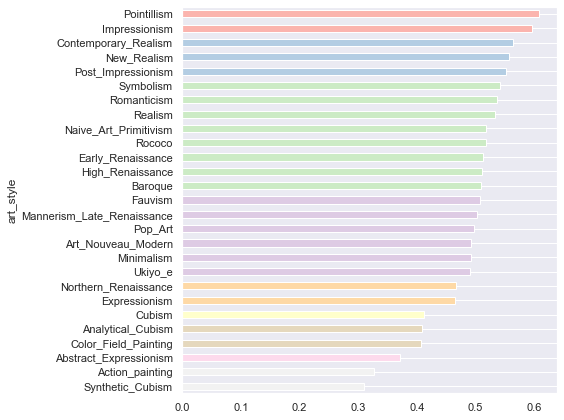

In [52]:
# Plot majority-dominance of emotions per art-style.
s = emo_domi.groupby('art_style').mean().sort_values()
norm = plt.Normalize(s.min(), s.max())
colors = plt.cm.Pastel1_r(norm(s.values))
fig = plt.figure(figsize=(8, 6))
ax = s.plot.barh(color=colors, )
ax.xaxis.grid() # horizontal lines
plt.tight_layout()
if save_figs:
    fig.savefig('emotional_majority_aggreement_per_art_style.jpg')

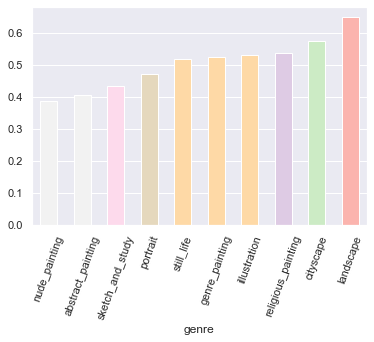

In [53]:
##
## Plot majority-dominance in emotions, per genre.
## 
# (recall - not all artworks have "genre" labels. working here with those that do.)

emo_domi.name = 'majority-aggreement'
temp = pd.merge(emo_domi, genre_info, on=['art_style', 'painting'])
s = temp.groupby('genre').mean().sort_values('majority-aggreement')
s = s['majority-aggreement']
norm = plt.Normalize(s.min(), s.max())
colors = plt.cm.Pastel1_r(norm(s.values))
fig = plt.figure()
ax = s.plot.bar(color=colors, grid=True, rot=70)
ax.xaxis.grid() # horizontal lines

if save_figs:
    fig.savefig('emotional_majority_aggreement_per_genre.jpg')

In [54]:
print('Majority-Dominance per genre (fractions).')
print(s)

Majority-Dominance per genre (fractions).
genre
nude_painting         0.386977
abstract_painting     0.405405
sketch_and_study      0.432893
portrait              0.470912
still_life            0.516710
genre_painting        0.523672
illustration          0.529973
religious_painting    0.535904
cityscape             0.572430
landscape             0.647187
Name: majority-aggreement, dtype: float64


In [55]:
# also now note the emotion that is the dominant (so we can count it per 1 of 9 "emotion" choices)
foo = partial(has_emotion_max_dominance, return_max=True)
emo_domi = grouped_artwork.apply(foo)
has_emo_domi = pd.Series([x[1] for x in emo_domi.values if x[0] == True]) # keeps only paintings where emo-dominance exists

# print the percentages (unormalized and normalized per emotion)
raw_emo_cnt = df.emotion.value_counts().to_dict()
emo_domi_cnt = has_emo_domi.value_counts().to_dict()
for emo in ARTEMIS_EMOTIONS:
    print("{:15}{:8}{:15.4f}".format(emo, emo_domi_cnt[emo], emo_domi_cnt[emo] / raw_emo_cnt[emo]))

amusement          3487         0.0818
awe                5767         0.0835
contentment       18742         0.1554
excitement         1807         0.0508
anger                84         0.0136
disgust             806         0.0380
fear               3857         0.0975
sadness            4318         0.0932
something else     2670         0.0553


In [56]:
is_met = df.utterance_spelled.apply(lambda x: sum([i in x for i in metaphorical_substrings]) >= 1)
print('Percent of annotations making a simile (approximate)', is_met.mean())

print('\nSamples:')
ds = df[is_met].sample(5)
for u in ds.utterance:
    print(u)

Percent of annotations making a simile (approximate) 0.20448919616888395

Samples:
Reminds me of something you may find in England.
The two women embracing each other look like they are happy to see each other finally after a long time
It looks like a dreary existence, dark, damp, and cold - the dominance of grey lends to the overall sadness of the mood.
the ships at mid frame look like a skyline
This make me think of a child drawing on the wall surrounded by lead paint chips ready to be consumed followed by severe illness.


Token Length per genre/art_style

genre
abstract_painting     14.339026
still_life            14.459752
nude_painting         14.504199
sketch_and_study      14.595872
landscape             14.605013
portrait              14.732299
cityscape             14.790963
religious_painting    14.855221
illustration          15.066015
genre_painting        15.084856
Name: tokens_len, dtype: float64
art_style
Pointillism                   12.992433
Synthetic_Cubism              13.215620
Analytical_Cubism             13.255474
Action_painting               13.274542
New_Realism                   13.445383
Fauvism                       13.571720
Contemporary_Realism          13.614957
Minimalism                    14.062752
Color_Field_Painting          14.094071
Ukiyo_e                       14.137575
Mannerism_Late_Renaissance    14.213860
Early_Renaissance             14.253575
High_Renaissance              14.324301
Pop_Art                       14.410603
Rococo                        14.5623

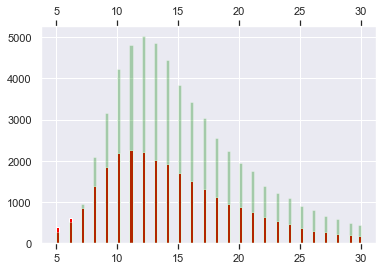

In [57]:
pedandic = True

if pedandic:
    print('Token Length per genre/art_style\n')
    print(df_with_genre.groupby('genre')['tokens_len'].mean().sort_values())
    print(df.groupby('art_style')['tokens_len'].mean().sort_values())
    
    fig, ax = plt.subplots()
    ax2 = ax.twiny()
    df_with_genre[df_with_genre['genre'] == 'abstract_painting']['tokens_len'].hist(bins=100, ax=ax, color='red')
    df_with_genre[df_with_genre['genre'] == 'genre_painting']['tokens_len'].hist(bins=100, ax=ax2, color='green', alpha=0.3)

Number of tokens per utterance (punctuations removed), for utterances with at most 50 tokens (100.00% of all utterances).


Text(0, 0.5, 'Number of utterances')

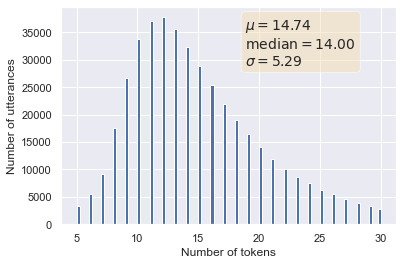

In [58]:
tokens_len = df.tokens_len[df.tokens_len <= 50]
print("Number of tokens per utterance (punctuations removed), for utterances with at most 50 tokens ({:.2f}% of all utterances).".format((df.tokens_len <= 50).mean() * 100))

mu = tokens_len.mean()
median = tokens_len.median()
sigma = tokens_len.std()
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))

ax = tokens_len.hist(bins=100)

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.55, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.xlabel('Number of tokens', fontsize=12)
plt.ylabel('Number of utterances', fontsize=12)

In [59]:
def rough_fine_grained_emotion_analysis_of_something_else(tokens):
    found_counter = 0
    fine_grained_emotion_category = None
    for t in tokens:        
        for f in LARGER_EMOTION_VOCAB:
            if t in f:
                found_counter += 1
                fine_grained_emotion_category = f[0]
    
    if found_counter == 1: # found_exactly_one
        return fine_grained_emotion_category
    else:
        return 'unclassified'

n_se = (df.emotion == 'something else').sum()
print('annotations with something-else choice:', n_se)

annotations with something-else choice: 48269


In [60]:
se = df[df.emotion == 'something else']
fg_se_emo = se['tokens'].apply(rough_fine_grained_emotion_analysis_of_something_else)
print('These emotion-words or synnonyms are found exactly once in these many SE annotations:')
fg_se_emo.value_counts()

These emotion-words or synnonyms are found exactly once in these many SE annotations:


unclassified      33803
confused           4793
bored              3618
curious            3420
happy               597
uncomfortable       321
anxiety             274
nostalgia           270
neutral             256
hope                254
creepy              249
depressing          126
overwhelmed          72
anticipation         45
bothered             45
shock                32
disappointment       27
shy                  14
shame                13
surprised            12
alerted              10
rage                  4
thrilled              4
grief                 3
insult                3
empowerment           2
exhilarating          2
Name: tokens, dtype: int64